In [1]:
from __future__ import division
from covertrace.data_array import Sites
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import abspath, dirname, join
%matplotlib inline

In [2]:
from covertrace import ops_filter
from covertrace import ops_plotter
from covertrace import ops_bool

In [3]:
data_folder = join(dirname(abspath(os.curdir)), 'covertrackdev', 'output')

### Clean the first dataset: Anisomycin stimulation followed by JNK inhibitor

*Sites* class provides a convenient interface for handling a complex live-cell data structure. Please take a look at Github for details.  
Let's first look at the dataset where JNK KTR were activated with anisomycin and then inactivated with JNK inhibitor.

In [4]:
parent_folder = join(data_folder, 'AnisoInh')
sub_folders = ['Pos001', 'Pos002']
conditions = ['AnisoInh', 'AnisoInh']
sites = Sites(parent_folder, sub_folders, conditions, file_name='df.npz')

First take a look at average traces for the cytoplasmic/nuclear ratio of median intensity.  
*Sites.iterate* will run an operation to the data indicated by *sites.staged.state*. 

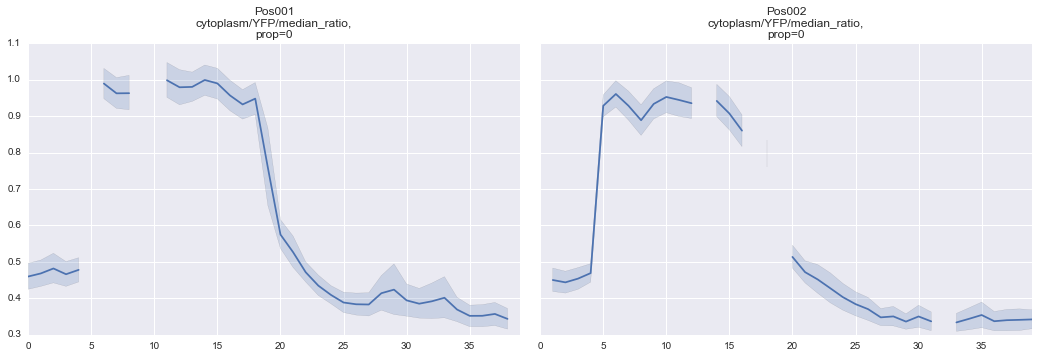

In [5]:
sites.set_state(['cytoplasm', 'YFP', 'median_ratio'])
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)

In [6]:
# You can see missing points are indicated by NaN. FIXME.   
interp = partial(ops_filter.interpolate_single_prop)
sites.iterate(interp)

Pos002: file_name is updated to arr_modified.npz


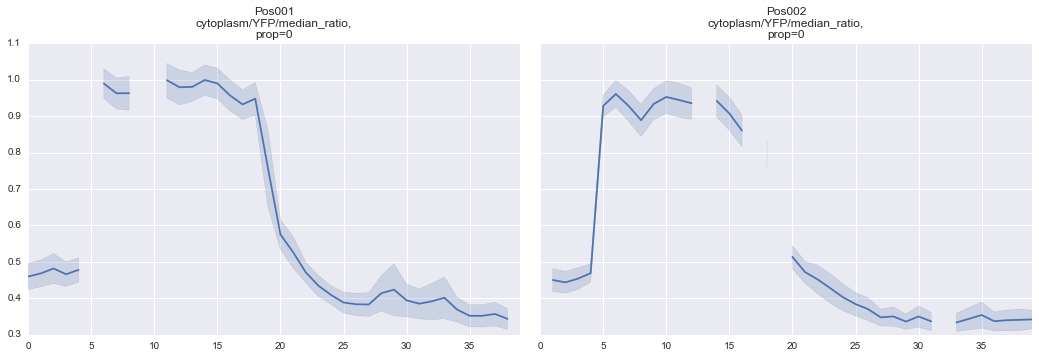

In [7]:
#interpolated
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
fig, axes = sites.iterate(plot_tsplot)

You can see the activation of JNK KTR followed by inhibition.  
Now take a look at a single-cell level traces.   

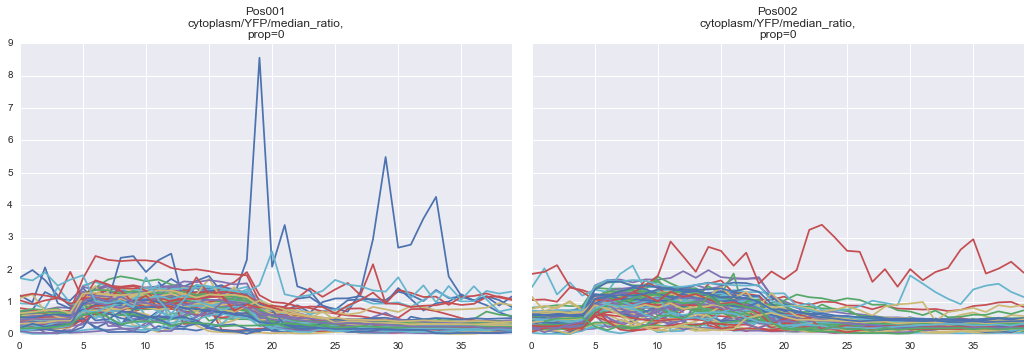

In [8]:
plot_all = partial(ops_plotter.plot_all)
fig, axes = sites.iterate(plot_all)

Now you can see traces at a single-cell level are much noisy.  
The typical range for JNK KTR cytoplasmic/nuclear ratio is 0.5-2.  
One typical cause of these outliers is there are cells with almost no reporters expressed. Let's see how intensity looks like.

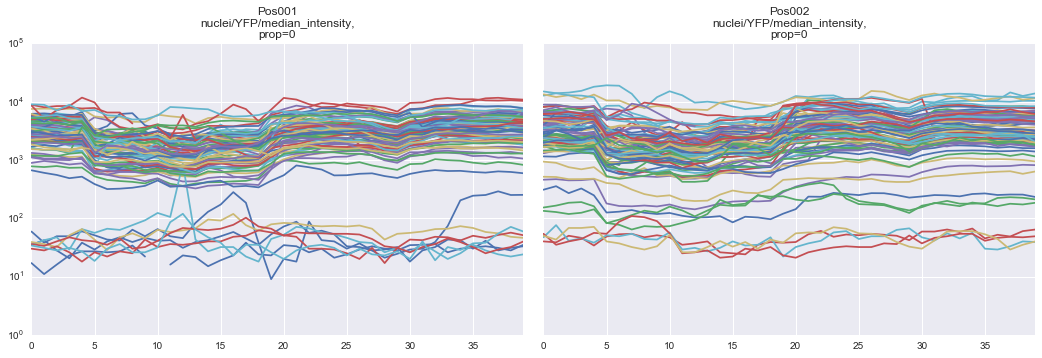

In [9]:
sites.set_state(['nuclei', 'YFP', 'median_intensity'])
plot_all_log = partial(ops_plotter.plot_all, logy=True)
fig, axes = sites.iterate(plot_all_log)

Indeed you see two distinct populations in terms of the reporter level in nuclei. We want to filter them.  
Assign "Property ID" 1 to the cells with the nuclear intensity lower than 100.

Pos002: file_name is updated to arr_modified.npz


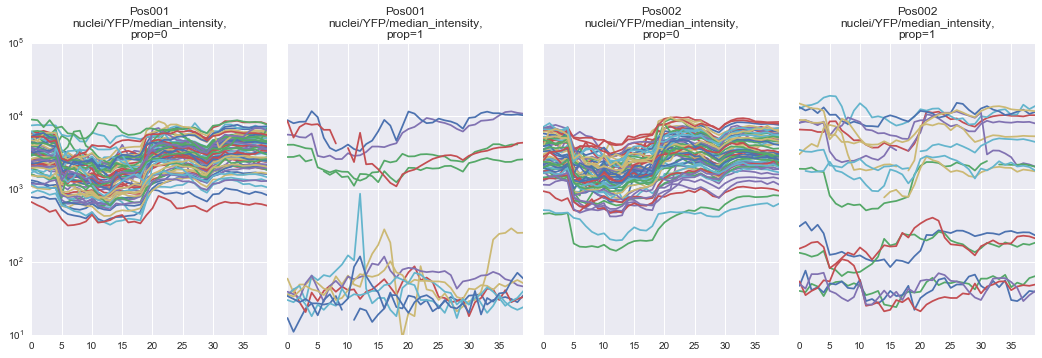

In [10]:
op = partial(ops_bool.filter_frames_by_range, LOWER=100)
sites.iterate(op, 1)
sites.propagate_prop(pid=1)
fig, axes = sites.iterate(plot_all_log)

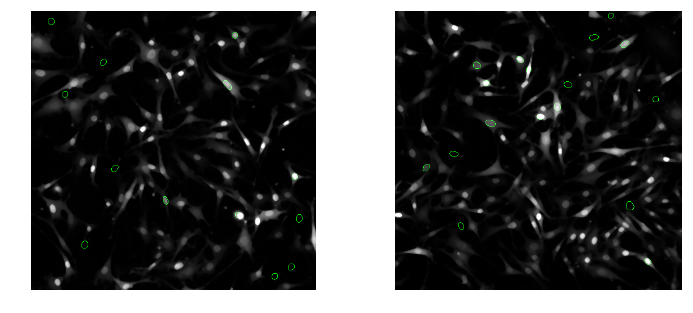

In [11]:
# You can visually check cells with prop=1 have low expression of YFP.
plt.figure(figsize=((12, 5)))
for num, site in enumerate(sites):
    ch_img = site.images.visualize.mark_prop(pid=1)
    plt.subplot(1, 2, num+1)
    plt.imshow(ch_img, cmap='Greys_r')
    plt.axis('off')

We can check that cells with prop=1 assigned have a noisier C/N ratio. 

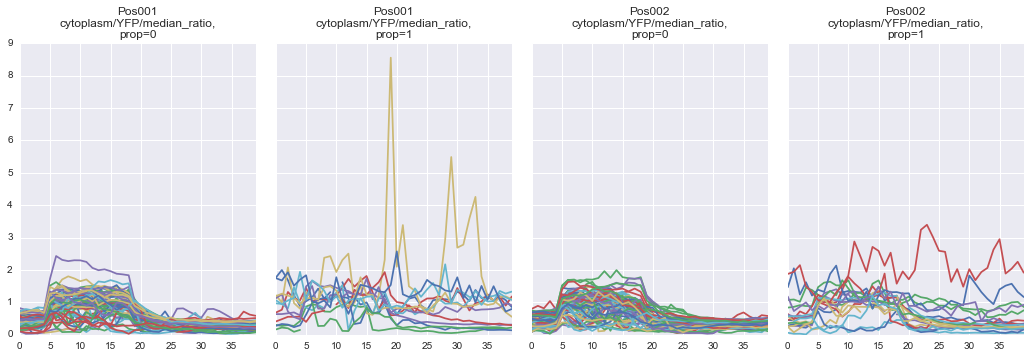

In [12]:
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
fig, axes = sites.iterate(plot_all)

In [13]:
# Remove these cells. 
sites.drop_prop(1)

Pos002: file_name is updated to arr_modified.npz


When signal-to-noise ratio is not so high, expression of the reporters can affect how we normalize nuclear intensity by cytoplasmic intensity.  
For simplicity, filter the cells out which have the expression level outside of the 5 and 95 percentile.

In [14]:
sites.staged.state = ['cytoplasm', 'YFP', 'median_intensity']
op = partial(ops_bool.filter_frames_by_percentile_stats, LOWER=5, UPPER=95)
sites.iterate(op, 1)
sites.propagate_prop(pid=1)
sites.staged.new_file_name = 'df_cleaned.npz'
sites.drop_prop(1)

Pos002: file_name is updated to df_cleaned.npz


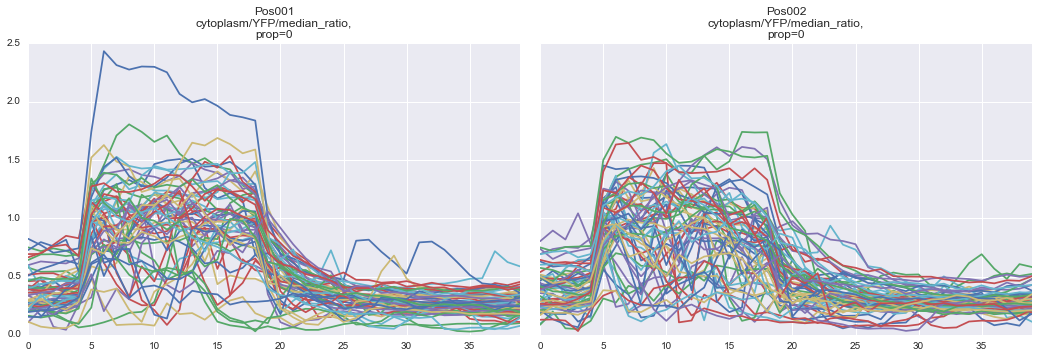

In [15]:
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
fig, axes = sites.iterate(plot_all)

Now traces are much less noisier. 

### Clean up the second dataset: LMB treatment of JNK KTR AA/EE mutants

Here we are going to clean up the different datasets. There are four positions; two of them are JNK KTR AA mutants and others are JNK KTR EE mutants.

In [16]:
parent_folder_mut = join(data_folder, 'LMB')
sub_folders_mut = ['Pos003', 'Pos004', 'Pos005', 'Pos006']
conditions_mut = ['JNK_AA', 'JNK_AA', 'JNK_EE', 'JNK_EE']
sites_mut = Sites(parent_folder_mut, sub_folders_mut, conditions_mut, file_name='df.npz')

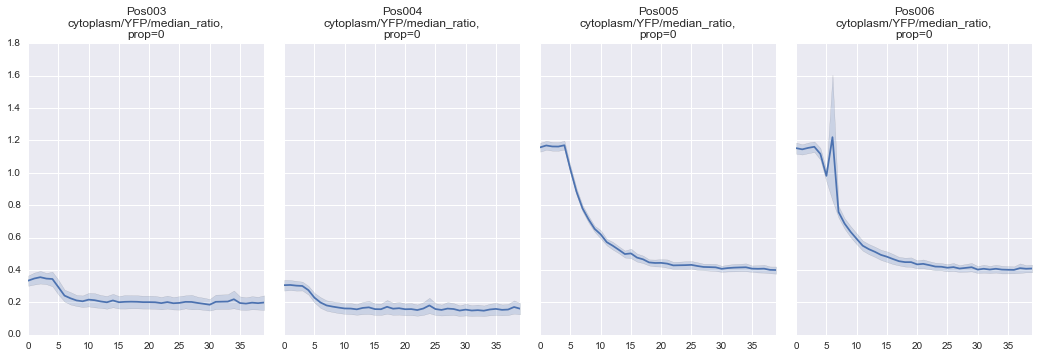

In [17]:
sites_mut.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
fig, axes = sites_mut.iterate(plot_tsplot)

C/N ratio of JNK KTR EE mutants is almost equivalent to the active JNK KTR, so it localizes to cytoplasm stronger than JNK AA mutants do at the beginning.  
After Leptomycin B treatment, you can see the inhibition of the export leading to the nuclear localization for all of the sites.

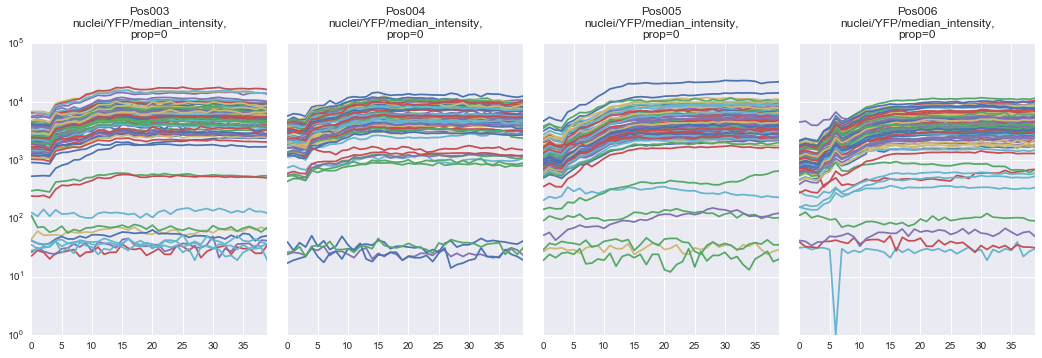

In [18]:
sites_mut.staged.state = ['nuclei', 'YFP', 'median_intensity']
fig, axes = sites_mut.iterate(plot_all_log)

In [19]:
op = partial(ops_bool.filter_frames_by_range, LOWER=800)
sites_mut.iterate(op, 1)
sites_mut.propagate_prop(pid=1)
sites_mut.drop_prop(1)

Pos006: file_name is updated to df_cleaned.npz


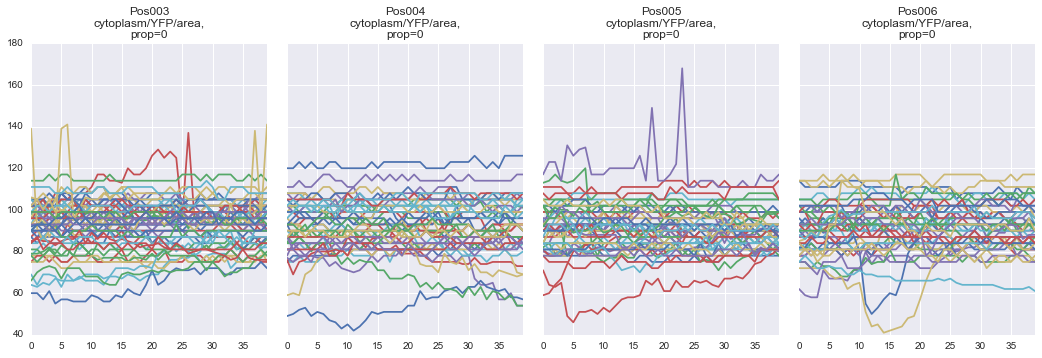

In [20]:
sites_mut.staged.state = ['cytoplasm', 'YFP', 'area']
fig, axes = sites_mut.iterate(plot_all)

In [21]:
sites_mut.staged.new_file_name = 'df_cleaned.npz'
op = partial(ops_bool.filter_frames_by_range, LOWER=70, UPPER=120)
sites_mut.iterate(op, 1)
sites_mut.propagate_prop(pid=1)
sites_mut.drop_prop(1)

Pos006: file_name is updated to df_cleaned.npz


In [22]:
sites_mut.staged.state = ['cytoplasm', 'YFP', 'median_intensity']
op = partial(ops_bool.filter_frames_by_percentile_stats, LOWER=5, UPPER=95)
sites_mut.iterate(op, 1)
sites_mut.propagate_prop(pid=1)
sites.staged.new_file_name = 'df_cleaned.npz'
sites_mut.drop_prop(1)

Pos006: file_name is updated to df_cleaned.npz


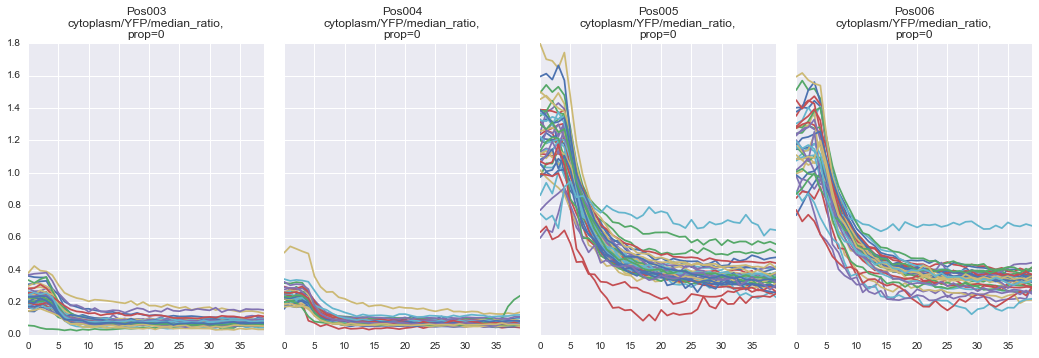

In [23]:
sites_mut.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
fig, axes = sites_mut.iterate(plot_all)

### Clean the third dataset. IL1B stimulation

In [24]:
parent_folder = join(data_folder, 'IL1B')
sub_folders = ['Pos005', 'Pos006', 'Pos007', 'Pos008']
conditions = ['IL1B', 'IL1B', 'IL1B', 'IL1B']
sites_il1b = Sites(parent_folder, sub_folders, conditions, file_name='df.npz')
sites_il1b.iterate(interp)

Pos008: file_name is updated to df_cleaned.npz


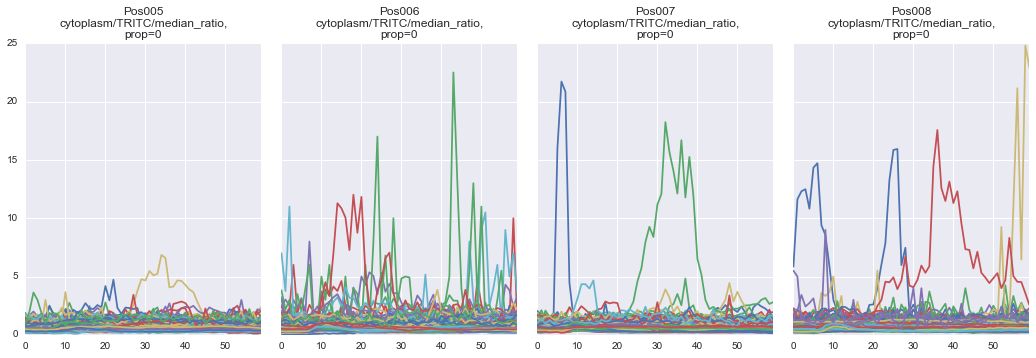

In [25]:
sites_il1b.staged.state = ['cytoplasm', 'TRITC', 'median_ratio']
fig, axes = sites_il1b.iterate(plot_all)

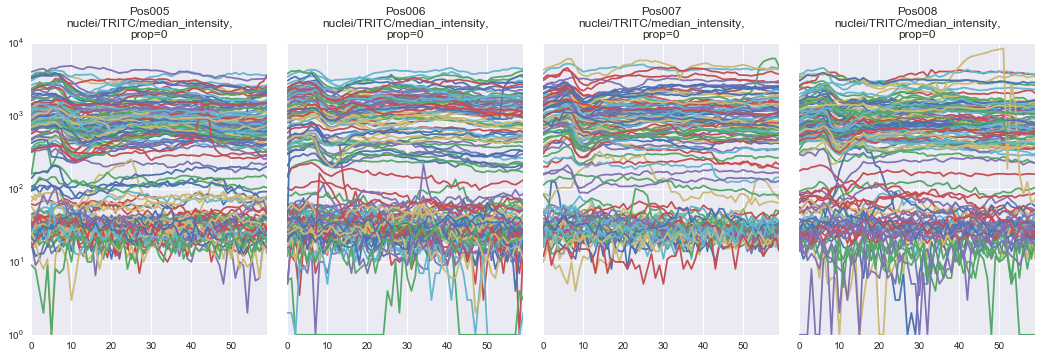

In [26]:
sites_il1b.staged.state = ['nuclei', 'TRITC', 'median_intensity']
fig, axes = sites_il1b.iterate(plot_all_log)

In [27]:
# Indeed you can see two population. Give "Property ID = 1" to cells with the intensity lower than 100.
op = partial(ops_bool.filter_frames_by_range, LOWER=200)
sites_il1b.iterate(op, 1)
sites_il1b.propagate_prop(pid=1)
sites_il1b.drop_prop(1)

Pos008: file_name is updated to df_cleaned.npz


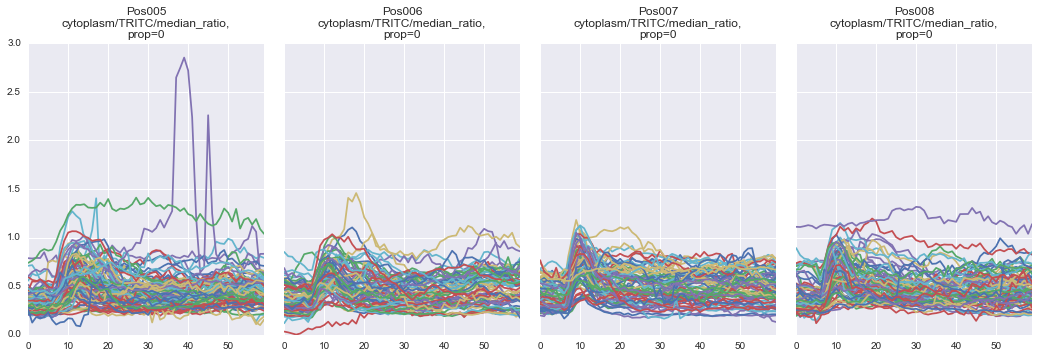

In [28]:
sites_il1b.staged.state = ['cytoplasm', 'TRITC', 'median_ratio']
fig, axes = sites_il1b.iterate(plot_all)

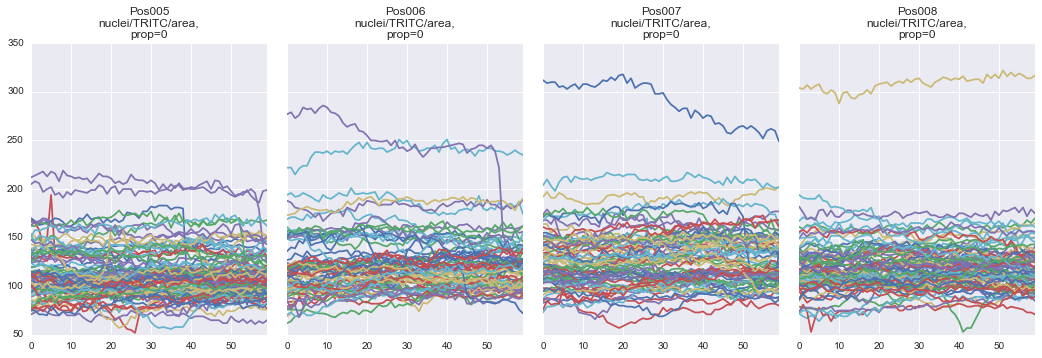

In [29]:
sites_il1b.staged.state = ['nuclei', 'TRITC', 'area']
fig, axes = sites_il1b.iterate(plot_all)

In [30]:
op = partial(ops_bool.filter_frames_by_range, LOWER=70, UPPER=180)
sites_il1b.iterate(op, 1)
sites_il1b.propagate_prop(pid=1)
sites_il1b.drop_prop(1)

Pos008: file_name is updated to df_cleaned.npz


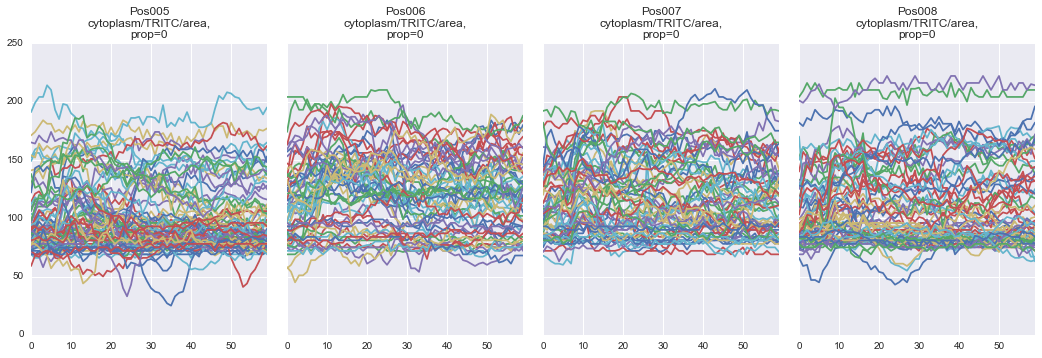

In [31]:
sites_il1b.staged.state = ['cytoplasm', 'TRITC', 'area']
fig, axes = sites_il1b.iterate(plot_all)

In [32]:
op = partial(ops_bool.filter_frames_by_range, LOWER=60, UPPER=185)
sites_il1b.iterate(op, 1)
sites_il1b.propagate_prop(pid=1)
sites_il1b.drop_prop(1)

Pos008: file_name is updated to df_cleaned.npz


In [33]:
sites_il1b.staged.state = ['cytoplasm', 'TRITC', 'median_intensity']
op = partial(ops_bool.filter_frames_by_percentile_stats, LOWER=5, UPPER=95)
sites_il1b.iterate(op, 1)
sites_il1b.propagate_prop(pid=1)
sites_il1b.drop_prop(1)

Pos008: file_name is updated to df_cleaned.npz


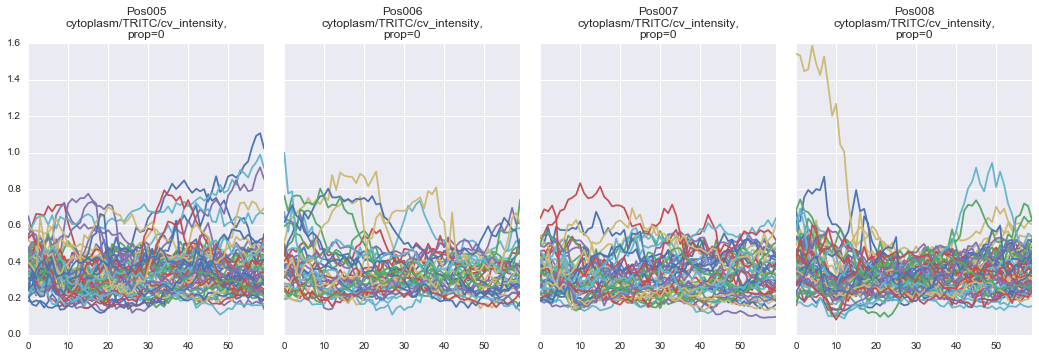

In [34]:
sites_il1b.staged.state = ['cytoplasm', 'TRITC', 'cv_intensity']
fig, axes = sites_il1b.iterate(plot_all)

In [35]:
op = partial(ops_bool.filter_frames_by_range, UPPER=0.7)
sites_il1b.iterate(op, 1)
sites_il1b.propagate_prop(pid=1)
sites_il1b.drop_prop(1)

Pos008: file_name is updated to df_cleaned.npz


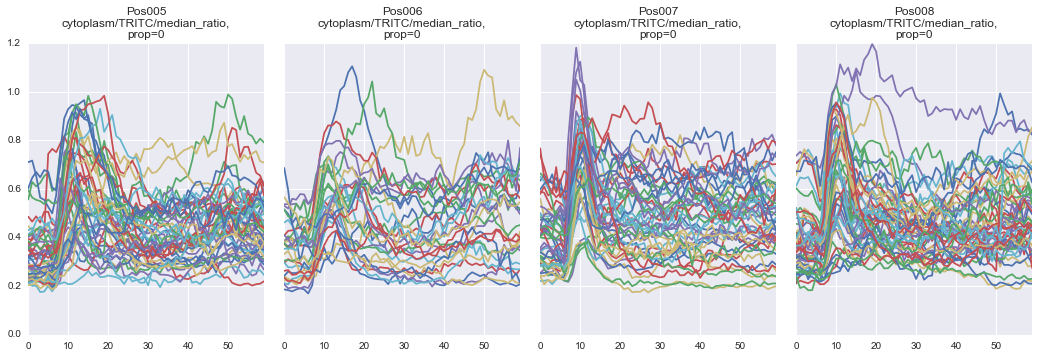

In [36]:
sites_il1b.staged.state = ['cytoplasm', 'TRITC', 'median_ratio']
fig, axes = sites_il1b.iterate(plot_all)

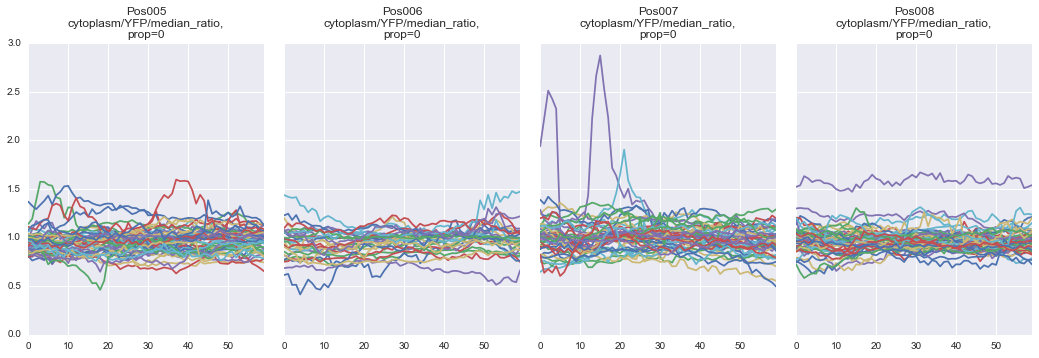

In [37]:
sites_il1b.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
fig, axes = sites_il1b.iterate(plot_all)

In [38]:
sites_il1b.staged.state = ['cytoplasm', 'YFP', 'median_intensity']
op = partial(ops_bool.filter_frames_by_percentile_stats, LOWER=5, UPPER=95)
sites_il1b.iterate(op, 1)
sites_il1b.propagate_prop(pid=1)
sites_il1b.drop_prop(1)

Pos008: file_name is updated to df_cleaned.npz


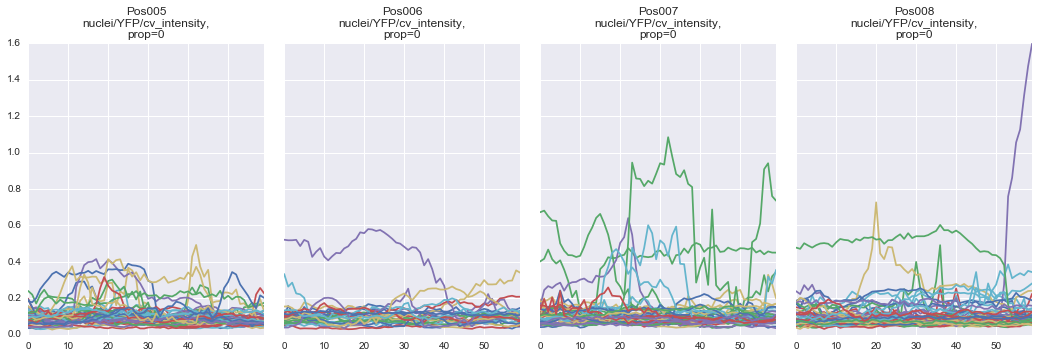

In [39]:
sites_il1b.staged.state = ['nuclei', 'YFP', 'cv_intensity']
fig, axes = sites_il1b.iterate(plot_all)

In [40]:
op = partial(ops_bool.filter_frames_by_range, UPPER=0.3)
sites_il1b.iterate(op, 1)
sites_il1b.propagate_prop(pid=1)
sites_il1b.drop_prop(1)

Pos008: file_name is updated to df_cleaned.npz


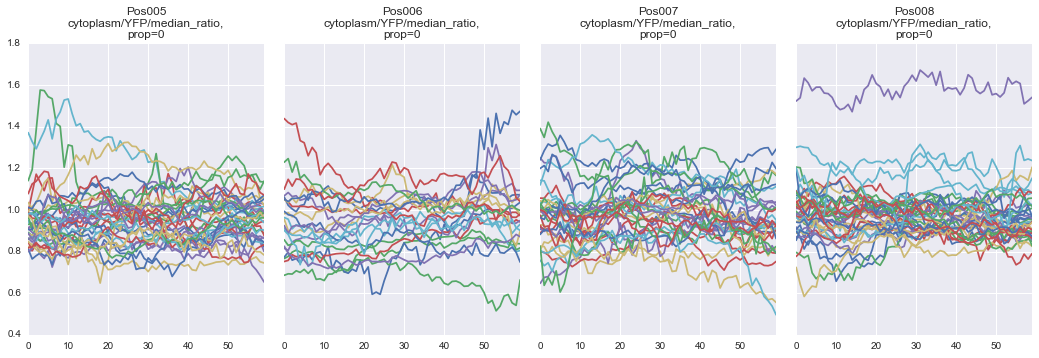

In [41]:
sites_il1b.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
fig, axes = sites_il1b.iterate(plot_all)